In [7]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

#Get the ISO-Codes
iso = pd.read_csv("../../Data/ISO/ISO.csv")

In [8]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../../Data/Networks/W_1_ij.csv', '../../Data/Networks/W_2_ij.csv', '../../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../../Data/Networks/W_3_ij.csv as W_3_ij


In [9]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 81353, Filtered rows: 69127
Filtered W_2_ij. Original rows: 34585, Filtered rows: 29382
Filtered W_3_ij. Original rows: 94775, Filtered rows: 78649


In [10]:
W_ij_dataframes["W_1_ij"]

,period,reporterISO,partnerISO,W_ij,inconsistency
0,1989,BRA,USA,190432.5000,380865.000
1,1989,BRA,ZWE,88225.5000,176451.000
2,1989,BRA,IND,3082.0000,6164.000
3,1989,BRA,NOR,10175.0000,20350.000
4,1989,BRA,NLD,7962.0000,15924.000
...,...,...,...,...,...
69122,2020,ZMB,CHN,15.6665,31.333
69123,2020,ZMB,IND,2469.7590,3215.920
69124,2020,ZMB,ITA,44477.1120,88954.224
69125,2020,ZMB,COD,28545.6125,57091.225


In [11]:
def calculate_pagerank_centrality_for_iso(df, iso_code):
    yearly_centrality = []
    if iso_code not in df['reporterISO'].unique() and iso_code not in df['partnerISO'].unique():
        return pd.DataFrame([{'period': year, 'pagerank_centrality': 0} for year in df['period'].unique()])
    
    for year, group in df.groupby('period'):
        G = nx.Graph()
        for _, row in group.iterrows():
            G.add_edge(row['reporterISO'], row['partnerISO'], weight=row['W_ij'])
        
        pagerank_centrality = nx.pagerank(G, weight='W_ij', tol=1e-08, max_iter=10000)
        
        centrality_value = pagerank_centrality.get(iso_code, 0)
        yearly_centrality.append({'period': year, 'pagerank_centrality': centrality_value})
    
    return pd.DataFrame(yearly_centrality)

df_centrality_W1 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_1_ij"], 'CHN')
df_centrality_W1 = df_centrality_W1.rename(columns={'pagerank_centrality': 'W_1_ij'})

df_centrality_W2 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_2_ij"], 'CHN')
df_centrality_W2 = df_centrality_W2.rename(columns={'pagerank_centrality': 'W_2_ij'})

df_centrality_W3 = calculate_pagerank_centrality_for_iso(W_ij_dataframes["W_3_ij"], 'CHN')
df_centrality_W3 = df_centrality_W3.rename(columns={'pagerank_centrality': 'W_3_ij'})

merged_df = pd.merge(df_centrality_W1, df_centrality_W2, on='period', how='outer').fillna(0)
merged_df = pd.merge(merged_df, df_centrality_W3, on='period', how='outer').fillna(0)


Saving plot to ../../../Writing/Master/figures/pagerank_centrality_CHN_plot.png with 300 DPI...
Plot saved successfully!


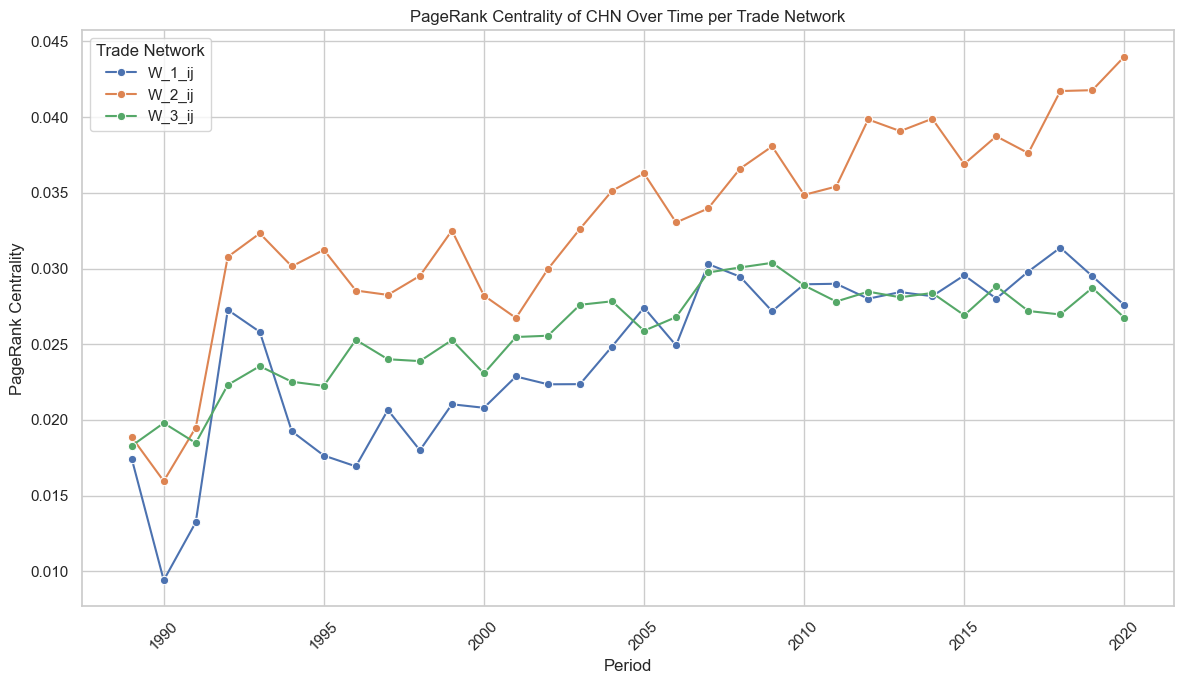

In [12]:
# Reshape the dataframe from wide to long format for Seaborn
long_format_df = pd.melt(merged_df, id_vars=['period'], var_name='DataFrame', value_name='pagerank_centrality')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=long_format_df,
    x='period',
    y='pagerank_centrality',
    hue='DataFrame',
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('PageRank Centrality')
plt.title('PageRank Centrality of CHN Over Time per Trade Network')
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

output_filename = '../../../Writing/Master/figures/pagerank_centrality_CHN_plot.png'
output_dpi = 300

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except FileNotFoundError:
    print(f"Error: The directory for {output_filename} does not exist. Please create it.")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

In [13]:
def pagerank(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
):
    """Returns the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key some subset of graph nodes and personalization value each of those.
      At least one personalization value must be non-zero.
      If not specified, a nodes personalization value will be zero.
      By default, a uniform distribution is used.

    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.
      The iteration will stop after a tolerance of ``len(G) * tol`` is reached.

    nstart : dictionary, optional
      Starting value of PageRank iteration for each node.

    weight : key, optional
      Edge data key to use as weight.  If None weights are set to 1.

    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified). This must be selected to result in an irreducible transition
      matrix (see notes under google_matrix). It may be common to have the
      dangling dict to be the same as the personalization dict.


    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value

    Examples
    --------
    >>> G = nx.DiGraph(nx.path_graph(4))
    >>> pr = nx.pagerank(G, alpha=0.9)

    Notes
    -----
    The eigenvector calculation is done by the power iteration method
    and has no guarantee of convergence.  The iteration will stop after
    an error tolerance of ``len(G) * tol`` has been reached. If the
    number of iterations exceed `max_iter`, a
    :exc:`networkx.exception.PowerIterationFailedConvergence` exception
    is raised.

    The PageRank algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs by converting each edge in the
    directed graph to two edges.

    See Also
    --------
    google_matrix
    :func:`~networkx.algorithms.bipartite.link_analysis.birank`

    Raises
    ------
    PowerIterationFailedConvergence
        If the algorithm fails to converge to the specified tolerance
        within the specified number of iterations of the power iteration
        method.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry,
       The PageRank citation ranking: Bringing order to the Web. 1999
       http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf

    """
    return _pagerank_scipy(
        G, alpha, personalization, max_iter, tol, nstart, weight, dangling
    )

In [14]:
def _pagerank_scipy(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
):
    """Returns the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    personalization: dict, optional
      The "personalization vector" consisting of a dictionary with a
      key some subset of graph nodes and personalization value each of those.
      At least one personalization value must be non-zero.
      If not specified, a nodes personalization value will be zero.
      By default, a uniform distribution is used.

    max_iter : integer, optional
      Maximum number of iterations in power method eigenvalue solver.

    tol : float, optional
      Error tolerance used to check convergence in power method solver.
      The iteration will stop after a tolerance of ``len(G) * tol`` is reached.

    nstart : dictionary, optional
      Starting value of PageRank iteration for each node.

    weight : key, optional
      Edge data key to use as weight.  If None weights are set to 1.

    dangling: dict, optional
      The outedges to be assigned to any "dangling" nodes, i.e., nodes without
      any outedges. The dict key is the node the outedge points to and the dict
      value is the weight of that outedge. By default, dangling nodes are given
      outedges according to the personalization vector (uniform if not
      specified) This must be selected to result in an irreducible transition
      matrix (see notes under google_matrix). It may be common to have the
      dangling dict to be the same as the personalization dict.

    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value

    Examples
    --------
    >>> from networkx.algorithms.link_analysis.pagerank_alg import _pagerank_scipy
    >>> G = nx.DiGraph(nx.path_graph(4))
    >>> pr = _pagerank_scipy(G, alpha=0.9)

    Notes
    -----
    The eigenvector calculation uses power iteration with a SciPy
    sparse matrix representation.

    This implementation works with Multi(Di)Graphs. For multigraphs the
    weight between two nodes is set to be the sum of all edge weights
    between those nodes.

    See Also
    --------
    pagerank

    Raises
    ------
    PowerIterationFailedConvergence
        If the algorithm fails to converge to the specified tolerance
        within the specified number of iterations of the power iteration
        method.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry,
       The PageRank citation ranking: Bringing order to the Web. 1999
       http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf
    """
    import numpy as np
    import scipy as sp

    N = len(G)
    if N == 0:
        return {}

    nodelist = list(G)
    A = nx.to_scipy_sparse_array(G, nodelist=nodelist, weight=weight, dtype=float)
    S = A.sum(axis=1)
    S[S != 0] = 1.0 / S[S != 0]
    # TODO: csr_array
    Q = sp.sparse.csr_array(sp.sparse.spdiags(S.T, 0, *A.shape))
    A = Q @ A

    # initial vector
    if nstart is None:
        x = np.repeat(1.0 / N, N)
    else:
        x = np.array([nstart.get(n, 0) for n in nodelist], dtype=float)
        x /= x.sum()

    # Personalization vector
    if personalization is None:
        p = np.repeat(1.0 / N, N)
    else:
        p = np.array([personalization.get(n, 0) for n in nodelist], dtype=float)
        if p.sum() == 0:
            raise ZeroDivisionError
        p /= p.sum()
    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = np.array([dangling.get(n, 0) for n in nodelist], dtype=float)
        dangling_weights /= dangling_weights.sum()
    is_dangling = np.where(S == 0)[0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x @ A + sum(x[is_dangling]) * dangling_weights) + (1 - alpha) * p
        # check convergence, l1 norm
        err = np.absolute(x - xlast).sum()
        if err < N * tol:
            return dict(zip(nodelist, map(float, x)))
    raise nx.PowerIterationFailedConvergence(max_iter)